Importeringen af de forskellige libarys, som skal bruges 

In [1]:
import keras
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras.models import Sequential 
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt 
%matplotlib inline
import os
import tensorflow as tf
import cv2
from keras.callbacks import EarlyStopping
import splitfolders


Difiner hvor indputtet kommer fra, og hvor outputtet kommer til at være

In [2]:
input_dir = "../4-Semester-Projekt/Input/simpsons_dataset"
output_dir = "./Output/data"

splitfolders.ratio(input_dir, output=output_dir, seed=1337, ratio=(.8, 0.1,0.1))

In [3]:
train_dir = "./Output/data/train"
val_dir = "./Output/data/val"
test_dir = "./Output/data/test"

image_size = (64, 64, 3)
# number of epochs to train top model 
epochs = 50 #this has been changed after multiple model run 
# batch size used by flow_from_directory and predict_generator 
batch_size = 100

labels = os.listdir(train_dir)

Et eksempel på et billed som bliver brugt

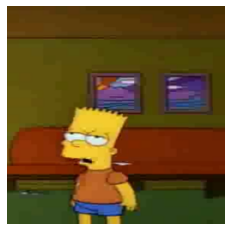

In [4]:
image_name = train_dir +"/bart_simpson/pic_0001.jpg" #Image to be used as query
def plotBart(image_location):
    image = cv2.imread(image_name)
    image = cv2.resize(image, (512,512))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)); plt.axis('off')
    return
plotBart(image_name)

In [5]:
train_datagen = ImageDataGenerator( rescale = 1./255,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2
                                    )

test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
training_set =  train_datagen.flow_from_directory(
                                                    train_dir,
                                                    target_size=image_size[:2],
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    color_mode='rgb'

)

val_set =  test_datagen.flow_from_directory(
                                                    val_dir,
                                                    target_size=image_size[:2],
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    color_mode='rgb'

)

Found 16727 images belonging to 43 classes.
Found 3063 images belonging to 43 classes.


In [7]:
for data_batch, labels_batch in training_set:
    print(data_batch.shape)
    break

(100, 64, 64, 3)


Sætter modellen til at være "Sequential", og tilføjer de forskellige lag til modellen

In [8]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=image_size, activation="relu"))
model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, (3, 3), padding='same', activation="relu")) 
model.add(Conv2D(256, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(len(labels), activation='softmax'))

In [9]:
model.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['accuracy'])

Den laver checkpoints, for udvikling af modellens accuracy

In [10]:
checkpoint_filepath = "checkpoints/{epoch:02d}-{val_accuracy:.2f}.hdf5"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

callbacks = [
             EarlyStopping(patience=5, monitor="val_accuracy", mode="max"),
             model_checkpoint_callback,
]

Selve træningen af modellen

In [12]:
history = model.fit_generator(  training_set,
                                epochs=epochs,
                                validation_data=val_set,
                                callbacks = callbacks
)

C:\Users\surin\AppData\Local\Temp\ipykernel_25160\2817835706.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(  training_set,


Epoch 1/50
168/168 [==============================] - 117s 694ms/step - loss: 2.8588 - accuracy: 0.1770 - val_loss: 2.4586 - val_accuracy: 0.3004
Epoch 2/50
168/168 [==============================] - 115s 682ms/step - loss: 2.3664 - accuracy: 0.3332 - val_loss: 1.7943 - val_accuracy: 0.4959
Epoch 3/50
168/168 [==============================] - 115s 682ms/step - loss: 1.9857 - accuracy: 0.4496 - val_loss: 1.4264 - val_accuracy: 0.6066
Epoch 4/50
168/168 [==============================] - 118s 699ms/step - loss: 1.7202 - accuracy: 0.5260 - val_loss: 1.1741 - val_accuracy: 0.6592
Epoch 5/50
168/168 [==============================] - 115s 686ms/step - loss: 1.5030 - accuracy: 0.5803 - val_loss: 0.9579 - val_accuracy: 0.7245
Epoch 6/50
168/168 [==============================] - 116s 691ms/step - loss: 1.3398 - accuracy: 0.6238 - val_loss: 0.9083 - val_accuracy: 0.7431
Epoch 7/50
168/168 [==============================] - 116s 689ms/step - loss: 1.1975 - accuracy: 0.6660 - val_loss: 0.7382 -

Et diagram som viser histrorikken fra modellens accuracy


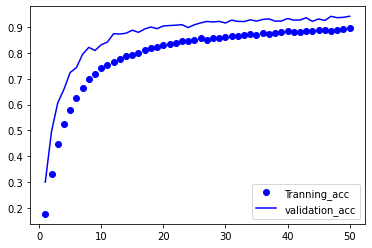

In [13]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Tranning_acc")
plt.plot(epochs, val_acc, "b", label="validation_acc")
plt.legend()

Boxplot over modellens accrucy ud for træningerne

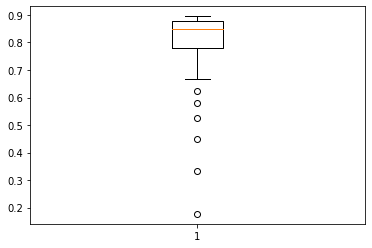

In [49]:
plt.boxplot(acc) 
plt.show()

Her gemmes modellen

In [19]:
model.save('model/model.h5')

In [20]:
saved_model = keras.models.load_model('model/model.h5')

In [21]:
saved_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 31, 31, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 29, 29, 64)        36928     
                                                        

Her gemmes modellen i databasen

In [22]:
import io
from gridfs import GridFS
from dal import *

fs = GridFS(db)
model_name = "model/model.h5"

with io.FileIO(model_name, 'r') as f:
    docId = fs.put(f, filename=model_name)

[{'name': 'Abraham Grampa Simpson'}, {'name': 'Agnes Skinner'}, {'name': 'Apu Nahasapeemapetilon'}, {'name': 'Barney Gumble'}, {'name': 'Bart Simpson'}, {'name': 'Bumblebee Man'}, {'name': 'Carl Carlson'}, {'name': 'Charles Montgomery Burns'}, {'name': 'Chief Wiggum'}, {'name': 'Cletus Spuckler'}, {'name': 'Comic Book Guy'}, {'name': 'Disco Stu'}, {'name': 'Edna Krabappel'}, {'name': 'Fat Tony'}, {'name': 'Gil'}, {'name': 'Groundskeeper Willie'}, {'name': 'Hans Moleman'}, {'name': 'Helen Lovejoy'}, {'name': 'Homer Simpson'}, {'name': 'Jasper Beardly'}, {'name': 'Jimbo Jones'}, {'name': 'Kent Brockman'}, {'name': 'Krusty The Clown'}, {'name': 'Lenny Leonard'}, {'name': 'Lionel Hutz'}, {'name': 'Lisa Simpson'}, {'name': 'Maggie Simpson'}, {'name': 'Marge Simpson'}, {'name': 'Martin Prince'}, {'name': 'Mayor Quimby'}, {'name': 'Milhouse Van Houten'}, {'name': 'Miss Hoover'}, {'name': 'Moe Szyslak'}, {'name': 'Ned Flanders'}, {'name': 'Nelson Muntz'}, {'name': 'Otto Mann'}, {'name': 'Patty

In [23]:
from bson import ObjectId

fs = GridFS(db)

with open('model/model_fromMongo.h5', 'wb') as f:
    f.write(fs.get(ObjectId(docId)).read())
